In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b10_b25_b50_b75_t1_mask_t1t2_native_k5_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 474)
(657450, 8)
validation
(74368, 474)
(74368, 8)
test
(91684, 474)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 474)]             0         


 dense (Dense)               (None, 1024)              486400    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1176456 (4.49 MB)


Trainable params: 1176456 (4.49 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:45 - loss: 1.5536 - STD: 0.0958 - MAE: 0.1869

 4/66 [>.............................] - ETA: 1s - loss: 1.3869 - STD: 0.1810 - MAE: 0.1501  

 8/66 [==>...........................] - ETA: 0s - loss: 1.3645 - STD: 0.1977 - MAE: 0.1435

11/66 [====>.........................] - ETA: 0s - loss: 1.3534 - STD: 0.1937 - MAE: 0.1449

15/66 [=====>........................] - ETA: 0s - loss: 1.3459 - STD: 0.1918 - MAE: 0.1456

18/66 [=======>......................] - ETA: 0s - loss: 1.3423 - STD: 0.1925 - MAE: 0.1454

22/66 [=========>....................] - ETA: 0s - loss: 1.3372 - STD: 0.1928 - MAE: 0.1452

26/66 [==========>...................] - ETA: 0s - loss: 1.3323 - STD: 0.1927 - MAE: 0.1451

30/66 [============>.................] - ETA: 0s - loss: 1.3297 - STD: 0.1927 - MAE: 0.1451

31/66 [=============>................] - ETA: 1s - loss: 1.3289 - STD: 0.1926 - MAE: 0.1451

35/66 [==============>...............] - ETA: 1s - loss: 1.3267 - STD: 0.1924 - MAE: 0.1451

39/66 [================>.............] - ETA: 1s - loss: 1.3243 - STD: 0.1922 - MAE: 0.1452

43/66 [==================>...........] - ETA: 0s - loss: 1.3230 - STD: 0.1924 - MAE: 0.1451

46/66 [===================>..........] - ETA: 0s - loss: 1.3219 - STD: 0.1925 - MAE: 0.1450

49/66 [=====================>........] - ETA: 0s - loss: 1.3209 - STD: 0.1924 - MAE: 0.1450

52/66 [======================>.......] - ETA: 0s - loss: 1.3205 - STD: 0.1924 - MAE: 0.1450

56/66 [========================>.....] - ETA: 0s - loss: 1.3188 - STD: 0.1923 - MAE: 0.1450

60/66 [==========================>...] - ETA: 0s - loss: 1.3188 - STD: 0.1924 - MAE: 0.1450

63/66 [===========================>..] - ETA: 0s - loss: 1.3187 - STD: 0.1923 - MAE: 0.1451

66/66 [==============================] - ETA: 0s - loss: 1.3186 - STD: 0.1922 - MAE: 0.1451

66/66 [==============================] - 4s 44ms/step - loss: 1.3186 - STD: 0.1922 - MAE: 0.1451 - val_loss: 1.2435 - val_STD: 0.1917 - val_MAE: 0.1419


Epoch 2/10000


 1/66 [..............................] - ETA: 2s - loss: 1.2890 - STD: 0.1917 - MAE: 0.1440

 4/66 [>.............................] - ETA: 1s - loss: 1.2922 - STD: 0.1935 - MAE: 0.1434

 8/66 [==>...........................] - ETA: 0s - loss: 1.2991 - STD: 0.1941 - MAE: 0.1436

11/66 [====>.........................] - ETA: 0s - loss: 1.3032 - STD: 0.1930 - MAE: 0.1443

15/66 [=====>........................] - ETA: 0s - loss: 1.3074 - STD: 0.1921 - MAE: 0.1449

19/66 [=======>......................] - ETA: 0s - loss: 1.3077 - STD: 0.1919 - MAE: 0.1450

23/66 [=========>....................] - ETA: 0s - loss: 1.3060 - STD: 0.1921 - MAE: 0.1448

26/66 [==========>...................] - ETA: 0s - loss: 1.3058 - STD: 0.1923 - MAE: 0.1448

29/66 [============>.................] - ETA: 0s - loss: 1.3059 - STD: 0.1922 - MAE: 0.1448

33/66 [==============>...............] - ETA: 0s - loss: 1.3051 - STD: 0.1921 - MAE: 0.1448

37/66 [===============>..............] - ETA: 0s - loss: 1.3055 - STD: 0.1921 - MAE: 0.1448

41/66 [=================>............] - ETA: 0s - loss: 1.3058 - STD: 0.1919 - MAE: 0.1449

44/66 [===================>..........] - ETA: 0s - loss: 1.3057 - STD: 0.1918 - MAE: 0.1450

48/66 [====================>.........] - ETA: 0s - loss: 1.3048 - STD: 0.1917 - MAE: 0.1449

52/66 [======================>.......] - ETA: 0s - loss: 1.3029 - STD: 0.1919 - MAE: 0.1447

56/66 [========================>.....] - ETA: 0s - loss: 1.3005 - STD: 0.1921 - MAE: 0.1445

60/66 [==========================>...] - ETA: 0s - loss: 1.2979 - STD: 0.1923 - MAE: 0.1443

63/66 [===========================>..] - ETA: 0s - loss: 1.2962 - STD: 0.1924 - MAE: 0.1442

66/66 [==============================] - ETA: 0s - loss: 1.2944 - STD: 0.1925 - MAE: 0.1441

66/66 [==============================] - 1s 19ms/step - loss: 1.2944 - STD: 0.1925 - MAE: 0.1441 - val_loss: 1.1727 - val_STD: 0.2054 - val_MAE: 0.1330


Epoch 3/10000


 1/66 [..............................] - ETA: 2s - loss: 1.2373 - STD: 0.2076 - MAE: 0.1356

 4/66 [>.............................] - ETA: 1s - loss: 1.2531 - STD: 0.1974 - MAE: 0.1402

 7/66 [==>...........................] - ETA: 1s - loss: 1.2522 - STD: 0.2002 - MAE: 0.1392

11/66 [====>.........................] - ETA: 0s - loss: 1.2518 - STD: 0.1998 - MAE: 0.1393

15/66 [=====>........................] - ETA: 0s - loss: 1.2519 - STD: 0.1994 - MAE: 0.1396

18/66 [=======>......................] - ETA: 0s - loss: 1.2524 - STD: 0.1989 - MAE: 0.1398

22/66 [=========>....................] - ETA: 0s - loss: 1.2493 - STD: 0.1984 - MAE: 0.1400

26/66 [==========>...................] - ETA: 0s - loss: 1.2459 - STD: 0.1987 - MAE: 0.1398

30/66 [============>.................] - ETA: 0s - loss: 1.2422 - STD: 0.1989 - MAE: 0.1396

33/66 [==============>...............] - ETA: 0s - loss: 1.2399 - STD: 0.1990 - MAE: 0.1395

36/66 [===============>..............] - ETA: 0s - loss: 1.2394 - STD: 0.1990 - MAE: 0.1395

40/66 [=================>............] - ETA: 0s - loss: 1.2376 - STD: 0.1989 - MAE: 0.1395

44/66 [===================>..........] - ETA: 0s - loss: 1.2362 - STD: 0.1989 - MAE: 0.1394

48/66 [====================>.........] - ETA: 0s - loss: 1.2340 - STD: 0.1989 - MAE: 0.1394

51/66 [======================>.......] - ETA: 0s - loss: 1.2331 - STD: 0.1990 - MAE: 0.1393

55/66 [========================>.....] - ETA: 0s - loss: 1.2316 - STD: 0.1991 - MAE: 0.1392

58/66 [=========================>....] - ETA: 0s - loss: 1.2304 - STD: 0.1993 - MAE: 0.1391

61/66 [==========================>...] - ETA: 0s - loss: 1.2291 - STD: 0.1993 - MAE: 0.1391

65/66 [============================>.] - ETA: 0s - loss: 1.2274 - STD: 0.1995 - MAE: 0.1389

66/66 [==============================] - 1s 19ms/step - loss: 1.2268 - STD: 0.1996 - MAE: 0.1389 - val_loss: 1.1271 - val_STD: 0.1973 - val_MAE: 0.1350


Epoch 4/10000


 1/66 [..............................] - ETA: 2s - loss: 1.2032 - STD: 0.2011 - MAE: 0.1376

 5/66 [=>............................] - ETA: 1s - loss: 1.2051 - STD: 0.1998 - MAE: 0.1382

 8/66 [==>...........................] - ETA: 0s - loss: 1.1979 - STD: 0.2000 - MAE: 0.1378

11/66 [====>.........................] - ETA: 0s - loss: 1.2000 - STD: 0.2006 - MAE: 0.1377

14/66 [=====>........................] - ETA: 0s - loss: 1.2005 - STD: 0.2006 - MAE: 0.1377

18/66 [=======>......................] - ETA: 0s - loss: 1.2010 - STD: 0.2002 - MAE: 0.1379

22/66 [=========>....................] - ETA: 0s - loss: 1.2005 - STD: 0.2007 - MAE: 0.1377

25/66 [==========>...................] - ETA: 0s - loss: 1.1995 - STD: 0.2005 - MAE: 0.1378

28/66 [===========>..................] - ETA: 0s - loss: 1.1983 - STD: 0.2009 - MAE: 0.1375

32/66 [=============>................] - ETA: 0s - loss: 1.1976 - STD: 0.2006 - MAE: 0.1377

36/66 [===============>..............] - ETA: 0s - loss: 1.1970 - STD: 0.2008 - MAE: 0.1376

40/66 [=================>............] - ETA: 0s - loss: 1.1961 - STD: 0.2006 - MAE: 0.1376

43/66 [==================>...........] - ETA: 0s - loss: 1.1955 - STD: 0.2009 - MAE: 0.1375

46/66 [===================>..........] - ETA: 0s - loss: 1.1949 - STD: 0.2008 - MAE: 0.1375

49/66 [=====================>........] - ETA: 0s - loss: 1.1941 - STD: 0.2009 - MAE: 0.1375

53/66 [=======================>......] - ETA: 0s - loss: 1.1934 - STD: 0.2010 - MAE: 0.1374

57/66 [========================>.....] - ETA: 0s - loss: 1.1927 - STD: 0.2010 - MAE: 0.1374

60/66 [==========================>...] - ETA: 0s - loss: 1.1926 - STD: 0.2010 - MAE: 0.1374

63/66 [===========================>..] - ETA: 0s - loss: 1.1917 - STD: 0.2010 - MAE: 0.1374

66/66 [==============================] - 1s 19ms/step - loss: 1.1909 - STD: 0.2010 - MAE: 0.1374 - val_loss: 1.0923 - val_STD: 0.2031 - val_MAE: 0.1319


Epoch 5/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1725 - STD: 0.2046 - MAE: 0.1356

 4/66 [>.............................] - ETA: 1s - loss: 1.1852 - STD: 0.2007 - MAE: 0.1378

 8/66 [==>...........................] - ETA: 0s - loss: 1.1791 - STD: 0.2012 - MAE: 0.1372

12/66 [====>.........................] - ETA: 0s - loss: 1.1726 - STD: 0.2016 - MAE: 0.1367

16/66 [======>.......................] - ETA: 0s - loss: 1.1741 - STD: 0.2021 - MAE: 0.1366

19/66 [=======>......................] - ETA: 0s - loss: 1.1721 - STD: 0.2020 - MAE: 0.1366

23/66 [=========>....................] - ETA: 0s - loss: 1.1712 - STD: 0.2020 - MAE: 0.1365

27/66 [===========>..................] - ETA: 0s - loss: 1.1695 - STD: 0.2022 - MAE: 0.1364

31/66 [=============>................] - ETA: 0s - loss: 1.1669 - STD: 0.2024 - MAE: 0.1363

34/66 [==============>...............] - ETA: 0s - loss: 1.1652 - STD: 0.2024 - MAE: 0.1362

37/66 [===============>..............] - ETA: 0s - loss: 1.1642 - STD: 0.2026 - MAE: 0.1360

40/66 [=================>............] - ETA: 0s - loss: 1.1639 - STD: 0.2024 - MAE: 0.1361

43/66 [==================>...........] - ETA: 0s - loss: 1.1631 - STD: 0.2028 - MAE: 0.1359

46/66 [===================>..........] - ETA: 0s - loss: 1.1631 - STD: 0.2026 - MAE: 0.1360

49/66 [=====================>........] - ETA: 0s - loss: 1.1622 - STD: 0.2028 - MAE: 0.1359

53/66 [=======================>......] - ETA: 0s - loss: 1.1612 - STD: 0.2029 - MAE: 0.1358

56/66 [========================>.....] - ETA: 0s - loss: 1.1606 - STD: 0.2028 - MAE: 0.1358

60/66 [==========================>...] - ETA: 0s - loss: 1.1596 - STD: 0.2030 - MAE: 0.1357

64/66 [============================>.] - ETA: 0s - loss: 1.1580 - STD: 0.2032 - MAE: 0.1355

66/66 [==============================] - 1s 19ms/step - loss: 1.1575 - STD: 0.2032 - MAE: 0.1355 - val_loss: 1.0569 - val_STD: 0.2101 - val_MAE: 0.1274


Epoch 6/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1352 - STD: 0.2114 - MAE: 0.1311

 5/66 [=>............................] - ETA: 1s - loss: 1.1321 - STD: 0.2064 - MAE: 0.1330

 8/66 [==>...........................] - ETA: 0s - loss: 1.1374 - STD: 0.2058 - MAE: 0.1335

12/66 [====>.........................] - ETA: 0s - loss: 1.1395 - STD: 0.2056 - MAE: 0.1337

15/66 [=====>........................] - ETA: 0s - loss: 1.1374 - STD: 0.2054 - MAE: 0.1336

19/66 [=======>......................] - ETA: 0s - loss: 1.1386 - STD: 0.2059 - MAE: 0.1334

23/66 [=========>....................] - ETA: 0s - loss: 1.1375 - STD: 0.2060 - MAE: 0.1333

26/66 [==========>...................] - ETA: 0s - loss: 1.1362 - STD: 0.2059 - MAE: 0.1333

30/66 [============>.................] - ETA: 0s - loss: 1.1354 - STD: 0.2060 - MAE: 0.1332

34/66 [==============>...............] - ETA: 0s - loss: 1.1349 - STD: 0.2061 - MAE: 0.1331

38/66 [================>.............] - ETA: 0s - loss: 1.1336 - STD: 0.2063 - MAE: 0.1330

42/66 [==================>...........] - ETA: 0s - loss: 1.1328 - STD: 0.2063 - MAE: 0.1329

45/66 [===================>..........] - ETA: 0s - loss: 1.1330 - STD: 0.2063 - MAE: 0.1329

49/66 [=====================>........] - ETA: 0s - loss: 1.1326 - STD: 0.2062 - MAE: 0.1330

53/66 [=======================>......] - ETA: 0s - loss: 1.1310 - STD: 0.2065 - MAE: 0.1328

57/66 [========================>.....] - ETA: 0s - loss: 1.1305 - STD: 0.2064 - MAE: 0.1328

60/66 [==========================>...] - ETA: 0s - loss: 1.1298 - STD: 0.2066 - MAE: 0.1327

63/66 [===========================>..] - ETA: 0s - loss: 1.1292 - STD: 0.2066 - MAE: 0.1326

66/66 [==============================] - 1s 19ms/step - loss: 1.1290 - STD: 0.2066 - MAE: 0.1326 - val_loss: 1.0425 - val_STD: 0.2073 - val_MAE: 0.1273


Epoch 7/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1171 - STD: 0.2091 - MAE: 0.1309

 5/66 [=>............................] - ETA: 1s - loss: 1.1146 - STD: 0.2097 - MAE: 0.1306

 9/66 [===>..........................] - ETA: 0s - loss: 1.1130 - STD: 0.2105 - MAE: 0.1301

12/66 [====>.........................] - ETA: 0s - loss: 1.1133 - STD: 0.2095 - MAE: 0.1306

16/66 [======>.......................] - ETA: 0s - loss: 1.1167 - STD: 0.2099 - MAE: 0.1306

20/66 [========>.....................] - ETA: 0s - loss: 1.1155 - STD: 0.2095 - MAE: 0.1307

24/66 [=========>....................] - ETA: 0s - loss: 1.1158 - STD: 0.2092 - MAE: 0.1308

28/66 [===========>..................] - ETA: 0s - loss: 1.1147 - STD: 0.2093 - MAE: 0.1307

31/66 [=============>................] - ETA: 0s - loss: 1.1142 - STD: 0.2093 - MAE: 0.1307

35/66 [==============>...............] - ETA: 0s - loss: 1.1145 - STD: 0.2091 - MAE: 0.1308

39/66 [================>.............] - ETA: 0s - loss: 1.1141 - STD: 0.2092 - MAE: 0.1308

42/66 [==================>...........] - ETA: 0s - loss: 1.1141 - STD: 0.2091 - MAE: 0.1308

46/66 [===================>..........] - ETA: 0s - loss: 1.1135 - STD: 0.2093 - MAE: 0.1307

50/66 [=====================>........] - ETA: 0s - loss: 1.1131 - STD: 0.2094 - MAE: 0.1306

54/66 [=======================>......] - ETA: 0s - loss: 1.1135 - STD: 0.2093 - MAE: 0.1307

58/66 [=========================>....] - ETA: 0s - loss: 1.1130 - STD: 0.2094 - MAE: 0.1306

61/66 [==========================>...] - ETA: 0s - loss: 1.1125 - STD: 0.2093 - MAE: 0.1306

64/66 [============================>.] - ETA: 0s - loss: 1.1118 - STD: 0.2093 - MAE: 0.1306

66/66 [==============================] - 1s 19ms/step - loss: 1.1115 - STD: 0.2095 - MAE: 0.1306 - val_loss: 1.0206 - val_STD: 0.2036 - val_MAE: 0.1278


Epoch 8/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1137 - STD: 0.2075 - MAE: 0.1315

 5/66 [=>............................] - ETA: 1s - loss: 1.1050 - STD: 0.2101 - MAE: 0.1300

 8/66 [==>...........................] - ETA: 0s - loss: 1.0992 - STD: 0.2108 - MAE: 0.1295

12/66 [====>.........................] - ETA: 0s - loss: 1.0979 - STD: 0.2111 - MAE: 0.1293

16/66 [======>.......................] - ETA: 0s - loss: 1.0978 - STD: 0.2107 - MAE: 0.1294

20/66 [========>.....................] - ETA: 0s - loss: 1.0980 - STD: 0.2108 - MAE: 0.1294

24/66 [=========>....................] - ETA: 0s - loss: 1.0983 - STD: 0.2109 - MAE: 0.1294

28/66 [===========>..................] - ETA: 0s - loss: 1.0988 - STD: 0.2107 - MAE: 0.1295

31/66 [=============>................] - ETA: 0s - loss: 1.0992 - STD: 0.2106 - MAE: 0.1296

34/66 [==============>...............] - ETA: 0s - loss: 1.0997 - STD: 0.2108 - MAE: 0.1295

38/66 [================>.............] - ETA: 0s - loss: 1.1005 - STD: 0.2107 - MAE: 0.1296

42/66 [==================>...........] - ETA: 0s - loss: 1.1005 - STD: 0.2106 - MAE: 0.1296

46/66 [===================>..........] - ETA: 0s - loss: 1.1002 - STD: 0.2106 - MAE: 0.1296

49/66 [=====================>........] - ETA: 0s - loss: 1.0997 - STD: 0.2108 - MAE: 0.1295

53/66 [=======================>......] - ETA: 0s - loss: 1.1000 - STD: 0.2107 - MAE: 0.1296

57/66 [========================>.....] - ETA: 0s - loss: 1.0996 - STD: 0.2108 - MAE: 0.1295

61/66 [==========================>...] - ETA: 0s - loss: 1.0993 - STD: 0.2108 - MAE: 0.1295

64/66 [============================>.] - ETA: 0s - loss: 1.0992 - STD: 0.2109 - MAE: 0.1295

66/66 [==============================] - 1s 19ms/step - loss: 1.0992 - STD: 0.2108 - MAE: 0.1295 - val_loss: 1.0135 - val_STD: 0.2137 - val_MAE: 0.1233


Epoch 9/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0960 - STD: 0.2173 - MAE: 0.1267

 4/66 [>.............................] - ETA: 1s - loss: 1.0916 - STD: 0.2104 - MAE: 0.1294

 7/66 [==>...........................] - ETA: 1s - loss: 1.0968 - STD: 0.2105 - MAE: 0.1296

10/66 [===>..........................] - ETA: 0s - loss: 1.0993 - STD: 0.2112 - MAE: 0.1294

14/66 [=====>........................] - ETA: 0s - loss: 1.0958 - STD: 0.2114 - MAE: 0.1291

18/66 [=======>......................] - ETA: 0s - loss: 1.0940 - STD: 0.2115 - MAE: 0.1290

21/66 [========>.....................] - ETA: 0s - loss: 1.0940 - STD: 0.2115 - MAE: 0.1290

25/66 [==========>...................] - ETA: 0s - loss: 1.0933 - STD: 0.2116 - MAE: 0.1289

29/66 [============>.................] - ETA: 0s - loss: 1.0930 - STD: 0.2116 - MAE: 0.1289

33/66 [==============>...............] - ETA: 0s - loss: 1.0941 - STD: 0.2115 - MAE: 0.1290

36/66 [===============>..............] - ETA: 0s - loss: 1.0954 - STD: 0.2116 - MAE: 0.1290

40/66 [=================>............] - ETA: 0s - loss: 1.0949 - STD: 0.2114 - MAE: 0.1291

44/66 [===================>..........] - ETA: 0s - loss: 1.0943 - STD: 0.2116 - MAE: 0.1289

48/66 [====================>.........] - ETA: 0s - loss: 1.0937 - STD: 0.2117 - MAE: 0.1289

52/66 [======================>.......] - ETA: 0s - loss: 1.0935 - STD: 0.2117 - MAE: 0.1289

56/66 [========================>.....] - ETA: 0s - loss: 1.0933 - STD: 0.2117 - MAE: 0.1289

59/66 [=========================>....] - ETA: 0s - loss: 1.0932 - STD: 0.2117 - MAE: 0.1289

62/66 [===========================>..] - ETA: 0s - loss: 1.0930 - STD: 0.2116 - MAE: 0.1289

65/66 [============================>.] - ETA: 0s - loss: 1.0930 - STD: 0.2116 - MAE: 0.1289

66/66 [==============================] - 1s 19ms/step - loss: 1.0928 - STD: 0.2117 - MAE: 0.1288 - val_loss: 1.0124 - val_STD: 0.2162 - val_MAE: 0.1220


Epoch 10/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0960 - STD: 0.2214 - MAE: 0.1242

 4/66 [>.............................] - ETA: 1s - loss: 1.0897 - STD: 0.2117 - MAE: 0.1284

 7/66 [==>...........................] - ETA: 1s - loss: 1.0951 - STD: 0.2116 - MAE: 0.1289

11/66 [====>.........................] - ETA: 0s - loss: 1.0913 - STD: 0.2120 - MAE: 0.1286

15/66 [=====>........................] - ETA: 0s - loss: 1.0894 - STD: 0.2120 - MAE: 0.1285

19/66 [=======>......................] - ETA: 0s - loss: 1.0908 - STD: 0.2119 - MAE: 0.1286

22/66 [=========>....................] - ETA: 0s - loss: 1.0886 - STD: 0.2122 - MAE: 0.1284

26/66 [==========>...................] - ETA: 0s - loss: 1.0872 - STD: 0.2122 - MAE: 0.1283

30/66 [============>.................] - ETA: 0s - loss: 1.0875 - STD: 0.2122 - MAE: 0.1283

34/66 [==============>...............] - ETA: 0s - loss: 1.0866 - STD: 0.2122 - MAE: 0.1283

37/66 [===============>..............] - ETA: 0s - loss: 1.0871 - STD: 0.2124 - MAE: 0.1282

41/66 [=================>............] - ETA: 0s - loss: 1.0876 - STD: 0.2124 - MAE: 0.1283

45/66 [===================>..........] - ETA: 0s - loss: 1.0878 - STD: 0.2122 - MAE: 0.1284

49/66 [=====================>........] - ETA: 0s - loss: 1.0891 - STD: 0.2122 - MAE: 0.1285

53/66 [=======================>......] - ETA: 0s - loss: 1.0889 - STD: 0.2121 - MAE: 0.1285

56/66 [========================>.....] - ETA: 0s - loss: 1.0888 - STD: 0.2122 - MAE: 0.1284

60/66 [==========================>...] - ETA: 0s - loss: 1.0886 - STD: 0.2122 - MAE: 0.1285

63/66 [===========================>..] - ETA: 0s - loss: 1.0884 - STD: 0.2121 - MAE: 0.1285

66/66 [==============================] - 1s 19ms/step - loss: 1.0872 - STD: 0.2123 - MAE: 0.1283 - val_loss: 1.0081 - val_STD: 0.2059 - val_MAE: 0.1263


Epoch 11/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0786 - STD: 0.2102 - MAE: 0.1290

 4/66 [>.............................] - ETA: 1s - loss: 1.0808 - STD: 0.2126 - MAE: 0.1281

 8/66 [==>...........................] - ETA: 0s - loss: 1.0790 - STD: 0.2126 - MAE: 0.1280

12/66 [====>.........................] - ETA: 0s - loss: 1.0812 - STD: 0.2122 - MAE: 0.1282

15/66 [=====>........................] - ETA: 0s - loss: 1.0820 - STD: 0.2129 - MAE: 0.1279

19/66 [=======>......................] - ETA: 0s - loss: 1.0850 - STD: 0.2125 - MAE: 0.1282

23/66 [=========>....................] - ETA: 0s - loss: 1.0837 - STD: 0.2127 - MAE: 0.1280

26/66 [==========>...................] - ETA: 0s - loss: 1.0839 - STD: 0.2127 - MAE: 0.1280

29/66 [============>.................] - ETA: 0s - loss: 1.0844 - STD: 0.2123 - MAE: 0.1282

32/66 [=============>................] - ETA: 0s - loss: 1.0840 - STD: 0.2122 - MAE: 0.1282

36/66 [===============>..............] - ETA: 0s - loss: 1.0847 - STD: 0.2122 - MAE: 0.1283

40/66 [=================>............] - ETA: 0s - loss: 1.0844 - STD: 0.2124 - MAE: 0.1282

43/66 [==================>...........] - ETA: 0s - loss: 1.0838 - STD: 0.2127 - MAE: 0.1281

46/66 [===================>..........] - ETA: 0s - loss: 1.0831 - STD: 0.2125 - MAE: 0.1281

49/66 [=====================>........] - ETA: 0s - loss: 1.0831 - STD: 0.2125 - MAE: 0.1281

52/66 [======================>.......] - ETA: 0s - loss: 1.0826 - STD: 0.2126 - MAE: 0.1280

55/66 [========================>.....] - ETA: 0s - loss: 1.0826 - STD: 0.2127 - MAE: 0.1280

58/66 [=========================>....] - ETA: 0s - loss: 1.0817 - STD: 0.2127 - MAE: 0.1279

62/66 [===========================>..] - ETA: 0s - loss: 1.0813 - STD: 0.2127 - MAE: 0.1279

66/66 [==============================] - ETA: 0s - loss: 1.0809 - STD: 0.2128 - MAE: 0.1278

66/66 [==============================] - 1s 19ms/step - loss: 1.0809 - STD: 0.2128 - MAE: 0.1278 - val_loss: 0.9965 - val_STD: 0.2151 - val_MAE: 0.1222


Epoch 12/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0837 - STD: 0.2190 - MAE: 0.1253

 4/66 [>.............................] - ETA: 1s - loss: 1.0775 - STD: 0.2134 - MAE: 0.1274

 7/66 [==>...........................] - ETA: 1s - loss: 1.0779 - STD: 0.2125 - MAE: 0.1277

10/66 [===>..........................] - ETA: 0s - loss: 1.0759 - STD: 0.2138 - MAE: 0.1271

13/66 [====>.........................] - ETA: 0s - loss: 1.0773 - STD: 0.2135 - MAE: 0.1273

17/66 [======>.......................] - ETA: 0s - loss: 1.0762 - STD: 0.2134 - MAE: 0.1273

21/66 [========>.....................] - ETA: 0s - loss: 1.0775 - STD: 0.2133 - MAE: 0.1274

24/66 [=========>....................] - ETA: 0s - loss: 1.0767 - STD: 0.2137 - MAE: 0.1272

28/66 [===========>..................] - ETA: 0s - loss: 1.0765 - STD: 0.2137 - MAE: 0.1272

32/66 [=============>................] - ETA: 0s - loss: 1.0759 - STD: 0.2136 - MAE: 0.1272

36/66 [===============>..............] - ETA: 0s - loss: 1.0760 - STD: 0.2135 - MAE: 0.1273

40/66 [=================>............] - ETA: 0s - loss: 1.0755 - STD: 0.2135 - MAE: 0.1273

43/66 [==================>...........] - ETA: 0s - loss: 1.0749 - STD: 0.2135 - MAE: 0.1273

47/66 [====================>.........] - ETA: 0s - loss: 1.0749 - STD: 0.2136 - MAE: 0.1272

51/66 [======================>.......] - ETA: 0s - loss: 1.0746 - STD: 0.2136 - MAE: 0.1273

55/66 [========================>.....] - ETA: 0s - loss: 1.0748 - STD: 0.2135 - MAE: 0.1273

59/66 [=========================>....] - ETA: 0s - loss: 1.0743 - STD: 0.2136 - MAE: 0.1272

62/66 [===========================>..] - ETA: 0s - loss: 1.0738 - STD: 0.2137 - MAE: 0.1272

65/66 [============================>.] - ETA: 0s - loss: 1.0739 - STD: 0.2136 - MAE: 0.1272

66/66 [==============================] - 1s 18ms/step - loss: 1.0738 - STD: 0.2137 - MAE: 0.1272 - val_loss: 1.0010 - val_STD: 0.2114 - val_MAE: 0.1240


Epoch 13/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0574 - STD: 0.2167 - MAE: 0.1251

 4/66 [>.............................] - ETA: 1s - loss: 1.0663 - STD: 0.2152 - MAE: 0.1260

 8/66 [==>...........................] - ETA: 0s - loss: 1.0724 - STD: 0.2143 - MAE: 0.1269

12/66 [====>.........................] - ETA: 0s - loss: 1.0716 - STD: 0.2147 - MAE: 0.1266

16/66 [======>.......................] - ETA: 0s - loss: 1.0699 - STD: 0.2147 - MAE: 0.1265

19/66 [=======>......................] - ETA: 0s - loss: 1.0701 - STD: 0.2144 - MAE: 0.1267

22/66 [=========>....................] - ETA: 0s - loss: 1.0711 - STD: 0.2140 - MAE: 0.1269

25/66 [==========>...................] - ETA: 0s - loss: 1.0708 - STD: 0.2140 - MAE: 0.1269

28/66 [===========>..................] - ETA: 0s - loss: 1.0692 - STD: 0.2141 - MAE: 0.1267

32/66 [=============>................] - ETA: 0s - loss: 1.0685 - STD: 0.2142 - MAE: 0.1267

35/66 [==============>...............] - ETA: 0s - loss: 1.0685 - STD: 0.2143 - MAE: 0.1267

38/66 [================>.............] - ETA: 0s - loss: 1.0691 - STD: 0.2141 - MAE: 0.1268

42/66 [==================>...........] - ETA: 0s - loss: 1.0703 - STD: 0.2140 - MAE: 0.1269

46/66 [===================>..........] - ETA: 0s - loss: 1.0718 - STD: 0.2139 - MAE: 0.1270

50/66 [=====================>........] - ETA: 0s - loss: 1.0713 - STD: 0.2141 - MAE: 0.1269

53/66 [=======================>......] - ETA: 0s - loss: 1.0716 - STD: 0.2142 - MAE: 0.1269

57/66 [========================>.....] - ETA: 0s - loss: 1.0718 - STD: 0.2142 - MAE: 0.1269

61/66 [==========================>...] - ETA: 0s - loss: 1.0715 - STD: 0.2142 - MAE: 0.1268

64/66 [============================>.] - ETA: 0s - loss: 1.0712 - STD: 0.2143 - MAE: 0.1268

66/66 [==============================] - 1s 19ms/step - loss: 1.0708 - STD: 0.2141 - MAE: 0.1268 - val_loss: 0.9942 - val_STD: 0.2173 - val_MAE: 0.1212


Epoch 14/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0636 - STD: 0.2211 - MAE: 0.1237

 5/66 [=>............................] - ETA: 1s - loss: 1.0706 - STD: 0.2155 - MAE: 0.1263

 8/66 [==>...........................] - ETA: 0s - loss: 1.0638 - STD: 0.2156 - MAE: 0.1258

11/66 [====>.........................] - ETA: 0s - loss: 1.0658 - STD: 0.2151 - MAE: 0.1261

14/66 [=====>........................] - ETA: 0s - loss: 1.0652 - STD: 0.2152 - MAE: 0.1261

18/66 [=======>......................] - ETA: 0s - loss: 1.0640 - STD: 0.2151 - MAE: 0.1261

22/66 [=========>....................] - ETA: 0s - loss: 1.0644 - STD: 0.2148 - MAE: 0.1263

25/66 [==========>...................] - ETA: 0s - loss: 1.0651 - STD: 0.2143 - MAE: 0.1266

28/66 [===========>..................] - ETA: 0s - loss: 1.0640 - STD: 0.2145 - MAE: 0.1264

31/66 [=============>................] - ETA: 0s - loss: 1.0629 - STD: 0.2149 - MAE: 0.1262

34/66 [==============>...............] - ETA: 0s - loss: 1.0624 - STD: 0.2150 - MAE: 0.1261

37/66 [===============>..............] - ETA: 0s - loss: 1.0623 - STD: 0.2148 - MAE: 0.1262

40/66 [=================>............] - ETA: 0s - loss: 1.0633 - STD: 0.2147 - MAE: 0.1263

43/66 [==================>...........] - ETA: 0s - loss: 1.0646 - STD: 0.2148 - MAE: 0.1263

46/66 [===================>..........] - ETA: 0s - loss: 1.0647 - STD: 0.2149 - MAE: 0.1262

49/66 [=====================>........] - ETA: 0s - loss: 1.0649 - STD: 0.2148 - MAE: 0.1263

52/66 [======================>.......] - ETA: 0s - loss: 1.0647 - STD: 0.2147 - MAE: 0.1263

55/66 [========================>.....] - ETA: 0s - loss: 1.0647 - STD: 0.2147 - MAE: 0.1263

58/66 [=========================>....] - ETA: 0s - loss: 1.0642 - STD: 0.2149 - MAE: 0.1263

61/66 [==========================>...] - ETA: 0s - loss: 1.0643 - STD: 0.2148 - MAE: 0.1263

64/66 [============================>.] - ETA: 0s - loss: 1.0637 - STD: 0.2148 - MAE: 0.1263

66/66 [==============================] - 1s 19ms/step - loss: 1.0634 - STD: 0.2148 - MAE: 0.1262 - val_loss: 0.9927 - val_STD: 0.2098 - val_MAE: 0.1243


Epoch 15/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0502 - STD: 0.2138 - MAE: 0.1262

 4/66 [>.............................] - ETA: 1s - loss: 1.0540 - STD: 0.2156 - MAE: 0.1254

 8/66 [==>...........................] - ETA: 0s - loss: 1.0569 - STD: 0.2157 - MAE: 0.1255

11/66 [====>.........................] - ETA: 0s - loss: 1.0585 - STD: 0.2157 - MAE: 0.1257

14/66 [=====>........................] - ETA: 0s - loss: 1.0597 - STD: 0.2154 - MAE: 0.1259

17/66 [======>.......................] - ETA: 0s - loss: 1.0592 - STD: 0.2150 - MAE: 0.1260

21/66 [========>.....................] - ETA: 0s - loss: 1.0583 - STD: 0.2153 - MAE: 0.1258

24/66 [=========>....................] - ETA: 0s - loss: 1.0587 - STD: 0.2155 - MAE: 0.1257

28/66 [===========>..................] - ETA: 0s - loss: 1.0581 - STD: 0.2155 - MAE: 0.1257

32/66 [=============>................] - ETA: 0s - loss: 1.0587 - STD: 0.2153 - MAE: 0.1258

35/66 [==============>...............] - ETA: 0s - loss: 1.0584 - STD: 0.2156 - MAE: 0.1257

39/66 [================>.............] - ETA: 0s - loss: 1.0588 - STD: 0.2156 - MAE: 0.1257

42/66 [==================>...........] - ETA: 0s - loss: 1.0581 - STD: 0.2153 - MAE: 0.1257

46/66 [===================>..........] - ETA: 0s - loss: 1.0590 - STD: 0.2153 - MAE: 0.1258

49/66 [=====================>........] - ETA: 0s - loss: 1.0592 - STD: 0.2152 - MAE: 0.1259

53/66 [=======================>......] - ETA: 0s - loss: 1.0592 - STD: 0.2152 - MAE: 0.1259

57/66 [========================>.....] - ETA: 0s - loss: 1.0588 - STD: 0.2152 - MAE: 0.1258

61/66 [==========================>...] - ETA: 0s - loss: 1.0588 - STD: 0.2153 - MAE: 0.1258

64/66 [============================>.] - ETA: 0s - loss: 1.0590 - STD: 0.2153 - MAE: 0.1258

66/66 [==============================] - 1s 19ms/step - loss: 1.0587 - STD: 0.2153 - MAE: 0.1258 - val_loss: 0.9852 - val_STD: 0.2112 - val_MAE: 0.1235


Epoch 16/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0510 - STD: 0.2141 - MAE: 0.1256

 4/66 [>.............................] - ETA: 1s - loss: 1.0569 - STD: 0.2150 - MAE: 0.1259

 7/66 [==>...........................] - ETA: 1s - loss: 1.0608 - STD: 0.2158 - MAE: 0.1258

10/66 [===>..........................] - ETA: 0s - loss: 1.0564 - STD: 0.2161 - MAE: 0.1254

13/66 [====>.........................] - ETA: 0s - loss: 1.0573 - STD: 0.2159 - MAE: 0.1256

16/66 [======>.......................] - ETA: 0s - loss: 1.0565 - STD: 0.2156 - MAE: 0.1256

20/66 [========>.....................] - ETA: 0s - loss: 1.0558 - STD: 0.2156 - MAE: 0.1256

23/66 [=========>....................] - ETA: 0s - loss: 1.0564 - STD: 0.2154 - MAE: 0.1257

27/66 [===========>..................] - ETA: 0s - loss: 1.0568 - STD: 0.2152 - MAE: 0.1258

31/66 [=============>................] - ETA: 0s - loss: 1.0561 - STD: 0.2153 - MAE: 0.1257

35/66 [==============>...............] - ETA: 0s - loss: 1.0560 - STD: 0.2154 - MAE: 0.1257

38/66 [================>.............] - ETA: 0s - loss: 1.0560 - STD: 0.2156 - MAE: 0.1256

42/66 [==================>...........] - ETA: 0s - loss: 1.0559 - STD: 0.2156 - MAE: 0.1256

45/66 [===================>..........] - ETA: 0s - loss: 1.0556 - STD: 0.2157 - MAE: 0.1255

49/66 [=====================>........] - ETA: 0s - loss: 1.0560 - STD: 0.2156 - MAE: 0.1256

52/66 [======================>.......] - ETA: 0s - loss: 1.0551 - STD: 0.2157 - MAE: 0.1255

56/66 [========================>.....] - ETA: 0s - loss: 1.0545 - STD: 0.2158 - MAE: 0.1254

59/66 [=========================>....] - ETA: 0s - loss: 1.0544 - STD: 0.2158 - MAE: 0.1254

63/66 [===========================>..] - ETA: 0s - loss: 1.0553 - STD: 0.2157 - MAE: 0.1255

66/66 [==============================] - 1s 18ms/step - loss: 1.0552 - STD: 0.2156 - MAE: 0.1255 - val_loss: 0.9957 - val_STD: 0.2192 - val_MAE: 0.1206


Epoch 17/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0560 - STD: 0.2239 - MAE: 0.1221

 5/66 [=>............................] - ETA: 1s - loss: 1.0525 - STD: 0.2171 - MAE: 0.1248

 8/66 [==>...........................] - ETA: 0s - loss: 1.0527 - STD: 0.2156 - MAE: 0.1254

11/66 [====>.........................] - ETA: 0s - loss: 1.0520 - STD: 0.2159 - MAE: 0.1253

15/66 [=====>........................] - ETA: 0s - loss: 1.0515 - STD: 0.2162 - MAE: 0.1251

19/66 [=======>......................] - ETA: 0s - loss: 1.0529 - STD: 0.2161 - MAE: 0.1253

23/66 [=========>....................] - ETA: 0s - loss: 1.0522 - STD: 0.2164 - MAE: 0.1251

27/66 [===========>..................] - ETA: 0s - loss: 1.0533 - STD: 0.2163 - MAE: 0.1251

30/66 [============>.................] - ETA: 0s - loss: 1.0526 - STD: 0.2163 - MAE: 0.1251

34/66 [==============>...............] - ETA: 0s - loss: 1.0518 - STD: 0.2163 - MAE: 0.1251

38/66 [================>.............] - ETA: 0s - loss: 1.0506 - STD: 0.2164 - MAE: 0.1250

41/66 [=================>............] - ETA: 0s - loss: 1.0512 - STD: 0.2163 - MAE: 0.1250

44/66 [===================>..........] - ETA: 0s - loss: 1.0515 - STD: 0.2162 - MAE: 0.1251

47/66 [====================>.........] - ETA: 0s - loss: 1.0517 - STD: 0.2161 - MAE: 0.1252

51/66 [======================>.......] - ETA: 0s - loss: 1.0522 - STD: 0.2161 - MAE: 0.1252

55/66 [========================>.....] - ETA: 0s - loss: 1.0522 - STD: 0.2161 - MAE: 0.1252

59/66 [=========================>....] - ETA: 0s - loss: 1.0524 - STD: 0.2161 - MAE: 0.1252

62/66 [===========================>..] - ETA: 0s - loss: 1.0528 - STD: 0.2162 - MAE: 0.1252

65/66 [============================>.] - ETA: 0s - loss: 1.0526 - STD: 0.2163 - MAE: 0.1251

66/66 [==============================] - 1s 19ms/step - loss: 1.0526 - STD: 0.2163 - MAE: 0.1251 - val_loss: 0.9848 - val_STD: 0.2139 - val_MAE: 0.1223


Epoch 18/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0666 - STD: 0.2151 - MAE: 0.1262

 4/66 [>.............................] - ETA: 1s - loss: 1.0571 - STD: 0.2156 - MAE: 0.1257

 8/66 [==>...........................] - ETA: 1s - loss: 1.0525 - STD: 0.2157 - MAE: 0.1254

12/66 [====>.........................] - ETA: 0s - loss: 1.0543 - STD: 0.2158 - MAE: 0.1254

16/66 [======>.......................] - ETA: 0s - loss: 1.0520 - STD: 0.2161 - MAE: 0.1251

19/66 [=======>......................] - ETA: 0s - loss: 1.0528 - STD: 0.2159 - MAE: 0.1253

22/66 [=========>....................] - ETA: 0s - loss: 1.0517 - STD: 0.2157 - MAE: 0.1253

26/66 [==========>...................] - ETA: 0s - loss: 1.0503 - STD: 0.2160 - MAE: 0.1251

30/66 [============>.................] - ETA: 0s - loss: 1.0479 - STD: 0.2163 - MAE: 0.1249

34/66 [==============>...............] - ETA: 0s - loss: 1.0471 - STD: 0.2163 - MAE: 0.1249

38/66 [================>.............] - ETA: 0s - loss: 1.0483 - STD: 0.2162 - MAE: 0.1250

42/66 [==================>...........] - ETA: 0s - loss: 1.0493 - STD: 0.2159 - MAE: 0.1252

46/66 [===================>..........] - ETA: 0s - loss: 1.0499 - STD: 0.2158 - MAE: 0.1252

49/66 [=====================>........] - ETA: 0s - loss: 1.0501 - STD: 0.2160 - MAE: 0.1251

52/66 [======================>.......] - ETA: 0s - loss: 1.0501 - STD: 0.2162 - MAE: 0.1251

56/66 [========================>.....] - ETA: 0s - loss: 1.0498 - STD: 0.2162 - MAE: 0.1250

60/66 [==========================>...] - ETA: 0s - loss: 1.0496 - STD: 0.2163 - MAE: 0.1250

63/66 [===========================>..] - ETA: 0s - loss: 1.0489 - STD: 0.2162 - MAE: 0.1250

66/66 [==============================] - 1s 19ms/step - loss: 1.0489 - STD: 0.2161 - MAE: 0.1250 - val_loss: 0.9797 - val_STD: 0.2177 - val_MAE: 0.1205


Epoch 19/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0497 - STD: 0.2206 - MAE: 0.1236

 4/66 [>.............................] - ETA: 1s - loss: 1.0465 - STD: 0.2167 - MAE: 0.1249

 7/66 [==>...........................] - ETA: 0s - loss: 1.0440 - STD: 0.2167 - MAE: 0.1247

10/66 [===>..........................] - ETA: 0s - loss: 1.0472 - STD: 0.2167 - MAE: 0.1249

14/66 [=====>........................] - ETA: 0s - loss: 1.0490 - STD: 0.2164 - MAE: 0.1250

18/66 [=======>......................] - ETA: 0s - loss: 1.0487 - STD: 0.2162 - MAE: 0.1251

22/66 [=========>....................] - ETA: 0s - loss: 1.0470 - STD: 0.2163 - MAE: 0.1250

26/66 [==========>...................] - ETA: 0s - loss: 1.0464 - STD: 0.2163 - MAE: 0.1249

29/66 [============>.................] - ETA: 0s - loss: 1.0464 - STD: 0.2165 - MAE: 0.1248

32/66 [=============>................] - ETA: 0s - loss: 1.0454 - STD: 0.2166 - MAE: 0.1247

36/66 [===============>..............] - ETA: 0s - loss: 1.0441 - STD: 0.2167 - MAE: 0.1246

40/66 [=================>............] - ETA: 0s - loss: 1.0444 - STD: 0.2167 - MAE: 0.1246

44/66 [===================>..........] - ETA: 0s - loss: 1.0447 - STD: 0.2167 - MAE: 0.1246

47/66 [====================>.........] - ETA: 0s - loss: 1.0441 - STD: 0.2169 - MAE: 0.1245

51/66 [======================>.......] - ETA: 0s - loss: 1.0442 - STD: 0.2169 - MAE: 0.1245

55/66 [========================>.....] - ETA: 0s - loss: 1.0442 - STD: 0.2168 - MAE: 0.1246

59/66 [=========================>....] - ETA: 0s - loss: 1.0434 - STD: 0.2168 - MAE: 0.1245

62/66 [===========================>..] - ETA: 0s - loss: 1.0427 - STD: 0.2169 - MAE: 0.1244

66/66 [==============================] - ETA: 0s - loss: 1.0425 - STD: 0.2169 - MAE: 0.1244

66/66 [==============================] - 1s 18ms/step - loss: 1.0425 - STD: 0.2169 - MAE: 0.1244 - val_loss: 0.9832 - val_STD: 0.2151 - val_MAE: 0.1218


Epoch 20/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0395 - STD: 0.2185 - MAE: 0.1235

 5/66 [=>............................] - ETA: 0s - loss: 1.0416 - STD: 0.2178 - MAE: 0.1239

 8/66 [==>...........................] - ETA: 0s - loss: 1.0436 - STD: 0.2180 - MAE: 0.1239

12/66 [====>.........................] - ETA: 0s - loss: 1.0435 - STD: 0.2170 - MAE: 0.1244

15/66 [=====>........................] - ETA: 0s - loss: 1.0439 - STD: 0.2171 - MAE: 0.1244

19/66 [=======>......................] - ETA: 0s - loss: 1.0434 - STD: 0.2169 - MAE: 0.1245

22/66 [=========>....................] - ETA: 0s - loss: 1.0426 - STD: 0.2169 - MAE: 0.1244

26/66 [==========>...................] - ETA: 0s - loss: 1.0414 - STD: 0.2171 - MAE: 0.1243

30/66 [============>.................] - ETA: 0s - loss: 1.0411 - STD: 0.2171 - MAE: 0.1243

34/66 [==============>...............] - ETA: 0s - loss: 1.0394 - STD: 0.2174 - MAE: 0.1241

37/66 [===============>..............] - ETA: 0s - loss: 1.0384 - STD: 0.2174 - MAE: 0.1240

40/66 [=================>............] - ETA: 0s - loss: 1.0388 - STD: 0.2173 - MAE: 0.1241

44/66 [===================>..........] - ETA: 0s - loss: 1.0380 - STD: 0.2173 - MAE: 0.1241

48/66 [====================>.........] - ETA: 0s - loss: 1.0380 - STD: 0.2173 - MAE: 0.1241

52/66 [======================>.......] - ETA: 0s - loss: 1.0384 - STD: 0.2172 - MAE: 0.1241

55/66 [========================>.....] - ETA: 0s - loss: 1.0381 - STD: 0.2173 - MAE: 0.1241

59/66 [=========================>....] - ETA: 0s - loss: 1.0377 - STD: 0.2173 - MAE: 0.1240

63/66 [===========================>..] - ETA: 0s - loss: 1.0380 - STD: 0.2173 - MAE: 0.1241

66/66 [==============================] - 1s 18ms/step - loss: 1.0377 - STD: 0.2173 - MAE: 0.1240 - val_loss: 0.9867 - val_STD: 0.2199 - val_MAE: 0.1198


Epoch 21/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0291 - STD: 0.2243 - MAE: 0.1203

 4/66 [>.............................] - ETA: 1s - loss: 1.0360 - STD: 0.2175 - MAE: 0.1239

 8/66 [==>...........................] - ETA: 0s - loss: 1.0321 - STD: 0.2190 - MAE: 0.1229

12/66 [====>.........................] - ETA: 0s - loss: 1.0403 - STD: 0.2185 - MAE: 0.1236

15/66 [=====>........................] - ETA: 0s - loss: 1.0418 - STD: 0.2177 - MAE: 0.1240

18/66 [=======>......................] - ETA: 0s - loss: 1.0401 - STD: 0.2175 - MAE: 0.1240

22/66 [=========>....................] - ETA: 0s - loss: 1.0424 - STD: 0.2174 - MAE: 0.1242

26/66 [==========>...................] - ETA: 0s - loss: 1.0436 - STD: 0.2172 - MAE: 0.1243

30/66 [============>.................] - ETA: 0s - loss: 1.0424 - STD: 0.2173 - MAE: 0.1242

33/66 [==============>...............] - ETA: 0s - loss: 1.0418 - STD: 0.2171 - MAE: 0.1243

37/66 [===============>..............] - ETA: 0s - loss: 1.0404 - STD: 0.2173 - MAE: 0.1241

40/66 [=================>............] - ETA: 0s - loss: 1.0398 - STD: 0.2174 - MAE: 0.1241

43/66 [==================>...........] - ETA: 0s - loss: 1.0402 - STD: 0.2174 - MAE: 0.1241

47/66 [====================>.........] - ETA: 0s - loss: 1.0399 - STD: 0.2174 - MAE: 0.1241

50/66 [=====================>........] - ETA: 0s - loss: 1.0393 - STD: 0.2175 - MAE: 0.1240

54/66 [=======================>......] - ETA: 0s - loss: 1.0393 - STD: 0.2174 - MAE: 0.1241

57/66 [========================>.....] - ETA: 0s - loss: 1.0389 - STD: 0.2175 - MAE: 0.1240

61/66 [==========================>...] - ETA: 0s - loss: 1.0390 - STD: 0.2174 - MAE: 0.1240

64/66 [============================>.] - ETA: 0s - loss: 1.0387 - STD: 0.2173 - MAE: 0.1241

66/66 [==============================] - 1s 18ms/step - loss: 1.0386 - STD: 0.2174 - MAE: 0.1240 - val_loss: 1.0068 - val_STD: 0.2126 - val_MAE: 0.1242


Epoch 22/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0366 - STD: 0.2150 - MAE: 0.1252

 4/66 [>.............................] - ETA: 1s - loss: 1.0520 - STD: 0.2159 - MAE: 0.1256

 7/66 [==>...........................] - ETA: 1s - loss: 1.0460 - STD: 0.2180 - MAE: 0.1243

11/66 [====>.........................] - ETA: 0s - loss: 1.0417 - STD: 0.2173 - MAE: 0.1243

15/66 [=====>........................] - ETA: 0s - loss: 1.0422 - STD: 0.2170 - MAE: 0.1245

19/66 [=======>......................] - ETA: 0s - loss: 1.0420 - STD: 0.2170 - MAE: 0.1244

22/66 [=========>....................] - ETA: 0s - loss: 1.0416 - STD: 0.2172 - MAE: 0.1243

25/66 [==========>...................] - ETA: 0s - loss: 1.0404 - STD: 0.2174 - MAE: 0.1242

29/66 [============>.................] - ETA: 0s - loss: 1.0392 - STD: 0.2173 - MAE: 0.1241

33/66 [==============>...............] - ETA: 0s - loss: 1.0392 - STD: 0.2172 - MAE: 0.1242

37/66 [===============>..............] - ETA: 0s - loss: 1.0378 - STD: 0.2173 - MAE: 0.1241

40/66 [=================>............] - ETA: 0s - loss: 1.0372 - STD: 0.2174 - MAE: 0.1240

44/66 [===================>..........] - ETA: 0s - loss: 1.0363 - STD: 0.2174 - MAE: 0.1240

48/66 [====================>.........] - ETA: 0s - loss: 1.0349 - STD: 0.2176 - MAE: 0.1238

52/66 [======================>.......] - ETA: 0s - loss: 1.0348 - STD: 0.2176 - MAE: 0.1238

55/66 [========================>.....] - ETA: 0s - loss: 1.0352 - STD: 0.2176 - MAE: 0.1238

59/66 [=========================>....] - ETA: 0s - loss: 1.0350 - STD: 0.2177 - MAE: 0.1238

63/66 [===========================>..] - ETA: 0s - loss: 1.0354 - STD: 0.2177 - MAE: 0.1238

66/66 [==============================] - 1s 18ms/step - loss: 1.0356 - STD: 0.2177 - MAE: 0.1238 - val_loss: 0.9804 - val_STD: 0.2150 - val_MAE: 0.1216


Epoch 23/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0347 - STD: 0.2167 - MAE: 0.1243

 4/66 [>.............................] - ETA: 1s - loss: 1.0371 - STD: 0.2171 - MAE: 0.1242

 7/66 [==>...........................] - ETA: 1s - loss: 1.0356 - STD: 0.2178 - MAE: 0.1237

11/66 [====>.........................] - ETA: 0s - loss: 1.0322 - STD: 0.2180 - MAE: 0.1235

14/66 [=====>........................] - ETA: 0s - loss: 1.0319 - STD: 0.2179 - MAE: 0.1236

18/66 [=======>......................] - ETA: 0s - loss: 1.0311 - STD: 0.2179 - MAE: 0.1235

22/66 [=========>....................] - ETA: 0s - loss: 1.0308 - STD: 0.2180 - MAE: 0.1235

26/66 [==========>...................] - ETA: 0s - loss: 1.0302 - STD: 0.2182 - MAE: 0.1234

29/66 [============>.................] - ETA: 0s - loss: 1.0313 - STD: 0.2178 - MAE: 0.1236

33/66 [==============>...............] - ETA: 0s - loss: 1.0313 - STD: 0.2177 - MAE: 0.1236

37/66 [===============>..............] - ETA: 0s - loss: 1.0308 - STD: 0.2178 - MAE: 0.1236

41/66 [=================>............] - ETA: 0s - loss: 1.0305 - STD: 0.2179 - MAE: 0.1235

45/66 [===================>..........] - ETA: 0s - loss: 1.0301 - STD: 0.2179 - MAE: 0.1235

48/66 [====================>.........] - ETA: 0s - loss: 1.0300 - STD: 0.2179 - MAE: 0.1235

52/66 [======================>.......] - ETA: 0s - loss: 1.0298 - STD: 0.2179 - MAE: 0.1235

56/66 [========================>.....] - ETA: 0s - loss: 1.0295 - STD: 0.2179 - MAE: 0.1235

60/66 [==========================>...] - ETA: 0s - loss: 1.0291 - STD: 0.2179 - MAE: 0.1234

64/66 [============================>.] - ETA: 0s - loss: 1.0296 - STD: 0.2180 - MAE: 0.1234

66/66 [==============================] - 1s 18ms/step - loss: 1.0293 - STD: 0.2181 - MAE: 0.1234 - val_loss: 1.0108 - val_STD: 0.2093 - val_MAE: 0.1254


Epoch 24/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0488 - STD: 0.2119 - MAE: 0.1268

 5/66 [=>............................] - ETA: 1s - loss: 1.0318 - STD: 0.2179 - MAE: 0.1235

 8/66 [==>...........................] - ETA: 0s - loss: 1.0286 - STD: 0.2178 - MAE: 0.1234

12/66 [====>.........................] - ETA: 0s - loss: 1.0280 - STD: 0.2183 - MAE: 0.1231

15/66 [=====>........................] - ETA: 0s - loss: 1.0292 - STD: 0.2183 - MAE: 0.1232

19/66 [=======>......................] - ETA: 0s - loss: 1.0301 - STD: 0.2178 - MAE: 0.1235

23/66 [=========>....................] - ETA: 0s - loss: 1.0304 - STD: 0.2176 - MAE: 0.1236

27/66 [===========>..................] - ETA: 0s - loss: 1.0290 - STD: 0.2180 - MAE: 0.1234

31/66 [=============>................] - ETA: 0s - loss: 1.0298 - STD: 0.2180 - MAE: 0.1234

35/66 [==============>...............] - ETA: 0s - loss: 1.0292 - STD: 0.2180 - MAE: 0.1234

38/66 [================>.............] - ETA: 0s - loss: 1.0293 - STD: 0.2181 - MAE: 0.1234

41/66 [=================>............] - ETA: 0s - loss: 1.0293 - STD: 0.2181 - MAE: 0.1234

45/66 [===================>..........] - ETA: 0s - loss: 1.0288 - STD: 0.2181 - MAE: 0.1233

49/66 [=====================>........] - ETA: 0s - loss: 1.0291 - STD: 0.2181 - MAE: 0.1234

53/66 [=======================>......] - ETA: 0s - loss: 1.0295 - STD: 0.2180 - MAE: 0.1234

56/66 [========================>.....] - ETA: 0s - loss: 1.0294 - STD: 0.2181 - MAE: 0.1234

59/66 [=========================>....] - ETA: 0s - loss: 1.0291 - STD: 0.2181 - MAE: 0.1234

63/66 [===========================>..] - ETA: 0s - loss: 1.0291 - STD: 0.2181 - MAE: 0.1234

66/66 [==============================] - 1s 18ms/step - loss: 1.0287 - STD: 0.2181 - MAE: 0.1234 - val_loss: 0.9889 - val_STD: 0.2167 - val_MAE: 0.1216


Epoch 25/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0321 - STD: 0.2192 - MAE: 0.1233

 4/66 [>.............................] - ETA: 1s - loss: 1.0240 - STD: 0.2189 - MAE: 0.1229

 8/66 [==>...........................] - ETA: 0s - loss: 1.0178 - STD: 0.2194 - MAE: 0.1222

12/66 [====>.........................] - ETA: 0s - loss: 1.0210 - STD: 0.2192 - MAE: 0.1225

15/66 [=====>........................] - ETA: 0s - loss: 1.0221 - STD: 0.2186 - MAE: 0.1228

18/66 [=======>......................] - ETA: 0s - loss: 1.0219 - STD: 0.2187 - MAE: 0.1228

21/66 [========>.....................] - ETA: 0s - loss: 1.0223 - STD: 0.2187 - MAE: 0.1228

25/66 [==========>...................] - ETA: 0s - loss: 1.0215 - STD: 0.2188 - MAE: 0.1227

28/66 [===========>..................] - ETA: 0s - loss: 1.0222 - STD: 0.2188 - MAE: 0.1227

31/66 [=============>................] - ETA: 0s - loss: 1.0219 - STD: 0.2189 - MAE: 0.1227

35/66 [==============>...............] - ETA: 0s - loss: 1.0222 - STD: 0.2187 - MAE: 0.1228

39/66 [================>.............] - ETA: 0s - loss: 1.0233 - STD: 0.2185 - MAE: 0.1229

43/66 [==================>...........] - ETA: 0s - loss: 1.0232 - STD: 0.2185 - MAE: 0.1229

46/66 [===================>..........] - ETA: 0s - loss: 1.0238 - STD: 0.2184 - MAE: 0.1230

49/66 [=====================>........] - ETA: 0s - loss: 1.0232 - STD: 0.2186 - MAE: 0.1229

53/66 [=======================>......] - ETA: 0s - loss: 1.0233 - STD: 0.2186 - MAE: 0.1229

57/66 [========================>.....] - ETA: 0s - loss: 1.0230 - STD: 0.2185 - MAE: 0.1229

61/66 [==========================>...] - ETA: 0s - loss: 1.0233 - STD: 0.2184 - MAE: 0.1230

65/66 [============================>.] - ETA: 0s - loss: 1.0233 - STD: 0.2185 - MAE: 0.1229

66/66 [==============================] - 1s 18ms/step - loss: 1.0233 - STD: 0.2187 - MAE: 0.1229 - val_loss: 0.9761 - val_STD: 0.2115 - val_MAE: 0.1229


Epoch 26/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0159 - STD: 0.2125 - MAE: 0.1248

 4/66 [>.............................] - ETA: 1s - loss: 1.0259 - STD: 0.2176 - MAE: 0.1233

 8/66 [==>...........................] - ETA: 0s - loss: 1.0213 - STD: 0.2176 - MAE: 0.1233

12/66 [====>.........................] - ETA: 0s - loss: 1.0228 - STD: 0.2181 - MAE: 0.1231

16/66 [======>.......................] - ETA: 0s - loss: 1.0232 - STD: 0.2184 - MAE: 0.1231

19/66 [=======>......................] - ETA: 0s - loss: 1.0222 - STD: 0.2188 - MAE: 0.1228

23/66 [=========>....................] - ETA: 0s - loss: 1.0206 - STD: 0.2185 - MAE: 0.1228

26/66 [==========>...................] - ETA: 0s - loss: 1.0210 - STD: 0.2186 - MAE: 0.1229

30/66 [============>.................] - ETA: 0s - loss: 1.0212 - STD: 0.2185 - MAE: 0.1229

33/66 [==============>...............] - ETA: 0s - loss: 1.0220 - STD: 0.2186 - MAE: 0.1229

36/66 [===============>..............] - ETA: 0s - loss: 1.0216 - STD: 0.2185 - MAE: 0.1229

40/66 [=================>............] - ETA: 0s - loss: 1.0213 - STD: 0.2187 - MAE: 0.1228

44/66 [===================>..........] - ETA: 0s - loss: 1.0222 - STD: 0.2187 - MAE: 0.1229

48/66 [====================>.........] - ETA: 0s - loss: 1.0229 - STD: 0.2185 - MAE: 0.1230

51/66 [======================>.......] - ETA: 0s - loss: 1.0239 - STD: 0.2184 - MAE: 0.1231

55/66 [========================>.....] - ETA: 0s - loss: 1.0237 - STD: 0.2184 - MAE: 0.1230

59/66 [=========================>....] - ETA: 0s - loss: 1.0237 - STD: 0.2186 - MAE: 0.1230

63/66 [===========================>..] - ETA: 0s - loss: 1.0232 - STD: 0.2186 - MAE: 0.1229

66/66 [==============================] - ETA: 0s - loss: 1.0230 - STD: 0.2186 - MAE: 0.1229

66/66 [==============================] - 1s 18ms/step - loss: 1.0230 - STD: 0.2186 - MAE: 0.1229 - val_loss: 0.9859 - val_STD: 0.2153 - val_MAE: 0.1219


Epoch 27/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0219 - STD: 0.2172 - MAE: 0.1237

 5/66 [=>............................] - ETA: 1s - loss: 1.0214 - STD: 0.2192 - MAE: 0.1225

 9/66 [===>..........................] - ETA: 0s - loss: 1.0204 - STD: 0.2187 - MAE: 0.1227

13/66 [====>.........................] - ETA: 0s - loss: 1.0182 - STD: 0.2186 - MAE: 0.1226

17/66 [======>.......................] - ETA: 0s - loss: 1.0182 - STD: 0.2186 - MAE: 0.1227

20/66 [========>.....................] - ETA: 0s - loss: 1.0178 - STD: 0.2189 - MAE: 0.1225

23/66 [=========>....................] - ETA: 0s - loss: 1.0188 - STD: 0.2192 - MAE: 0.1224

27/66 [===========>..................] - ETA: 0s - loss: 1.0184 - STD: 0.2191 - MAE: 0.1225

31/66 [=============>................] - ETA: 0s - loss: 1.0188 - STD: 0.2189 - MAE: 0.1226

34/66 [==============>...............] - ETA: 0s - loss: 1.0187 - STD: 0.2189 - MAE: 0.1226

37/66 [===============>..............] - ETA: 0s - loss: 1.0192 - STD: 0.2188 - MAE: 0.1226

40/66 [=================>............] - ETA: 0s - loss: 1.0192 - STD: 0.2189 - MAE: 0.1226

43/66 [==================>...........] - ETA: 0s - loss: 1.0190 - STD: 0.2189 - MAE: 0.1226

47/66 [====================>.........] - ETA: 0s - loss: 1.0194 - STD: 0.2190 - MAE: 0.1226

50/66 [=====================>........] - ETA: 0s - loss: 1.0196 - STD: 0.2190 - MAE: 0.1226

53/66 [=======================>......] - ETA: 0s - loss: 1.0201 - STD: 0.2189 - MAE: 0.1226

57/66 [========================>.....] - ETA: 0s - loss: 1.0201 - STD: 0.2189 - MAE: 0.1226

61/66 [==========================>...] - ETA: 0s - loss: 1.0199 - STD: 0.2188 - MAE: 0.1227

65/66 [============================>.] - ETA: 0s - loss: 1.0201 - STD: 0.2188 - MAE: 0.1227

66/66 [==============================] - 1s 18ms/step - loss: 1.0201 - STD: 0.2188 - MAE: 0.1227 - val_loss: 0.9768 - val_STD: 0.2257 - val_MAE: 0.1171


Epoch 28/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0240 - STD: 0.2267 - MAE: 0.1192

 5/66 [=>............................] - ETA: 0s - loss: 1.0181 - STD: 0.2200 - MAE: 0.1220

 9/66 [===>..........................] - ETA: 0s - loss: 1.0199 - STD: 0.2194 - MAE: 0.1225

12/66 [====>.........................] - ETA: 0s - loss: 1.0224 - STD: 0.2191 - MAE: 0.1227

16/66 [======>.......................] - ETA: 0s - loss: 1.0210 - STD: 0.2190 - MAE: 0.1227

20/66 [========>.....................] - ETA: 0s - loss: 1.0193 - STD: 0.2192 - MAE: 0.1225

24/66 [=========>....................] - ETA: 0s - loss: 1.0185 - STD: 0.2193 - MAE: 0.1224

27/66 [===========>..................] - ETA: 0s - loss: 1.0186 - STD: 0.2192 - MAE: 0.1225

31/66 [=============>................] - ETA: 0s - loss: 1.0191 - STD: 0.2192 - MAE: 0.1225

35/66 [==============>...............] - ETA: 0s - loss: 1.0184 - STD: 0.2190 - MAE: 0.1226

39/66 [================>.............] - ETA: 0s - loss: 1.0184 - STD: 0.2190 - MAE: 0.1226

42/66 [==================>...........] - ETA: 0s - loss: 1.0178 - STD: 0.2190 - MAE: 0.1226

45/66 [===================>..........] - ETA: 0s - loss: 1.0175 - STD: 0.2191 - MAE: 0.1225

48/66 [====================>.........] - ETA: 0s - loss: 1.0181 - STD: 0.2190 - MAE: 0.1226

52/66 [======================>.......] - ETA: 0s - loss: 1.0173 - STD: 0.2192 - MAE: 0.1224

56/66 [========================>.....] - ETA: 0s - loss: 1.0168 - STD: 0.2194 - MAE: 0.1223

59/66 [=========================>....] - ETA: 0s - loss: 1.0167 - STD: 0.2192 - MAE: 0.1224

62/66 [===========================>..] - ETA: 0s - loss: 1.0166 - STD: 0.2191 - MAE: 0.1224

66/66 [==============================] - ETA: 0s - loss: 1.0172 - STD: 0.2192 - MAE: 0.1224

66/66 [==============================] - 1s 18ms/step - loss: 1.0172 - STD: 0.2192 - MAE: 0.1224 - val_loss: 1.0014 - val_STD: 0.2146 - val_MAE: 0.1222


Epoch 29/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0129 - STD: 0.2185 - MAE: 0.1221

 4/66 [>.............................] - ETA: 1s - loss: 1.0223 - STD: 0.2187 - MAE: 0.1228

 8/66 [==>...........................] - ETA: 0s - loss: 1.0195 - STD: 0.2180 - MAE: 0.1230

12/66 [====>.........................] - ETA: 0s - loss: 1.0203 - STD: 0.2181 - MAE: 0.1231

16/66 [======>.......................] - ETA: 0s - loss: 1.0204 - STD: 0.2188 - MAE: 0.1228

19/66 [=======>......................] - ETA: 0s - loss: 1.0212 - STD: 0.2190 - MAE: 0.1227

23/66 [=========>....................] - ETA: 0s - loss: 1.0218 - STD: 0.2190 - MAE: 0.1227

27/66 [===========>..................] - ETA: 0s - loss: 1.0203 - STD: 0.2190 - MAE: 0.1226

31/66 [=============>................] - ETA: 0s - loss: 1.0191 - STD: 0.2190 - MAE: 0.1226

34/66 [==============>...............] - ETA: 0s - loss: 1.0190 - STD: 0.2190 - MAE: 0.1226

37/66 [===============>..............] - ETA: 0s - loss: 1.0186 - STD: 0.2189 - MAE: 0.1226

41/66 [=================>............] - ETA: 0s - loss: 1.0188 - STD: 0.2187 - MAE: 0.1227

45/66 [===================>..........] - ETA: 0s - loss: 1.0188 - STD: 0.2187 - MAE: 0.1227

49/66 [=====================>........] - ETA: 0s - loss: 1.0188 - STD: 0.2189 - MAE: 0.1226

52/66 [======================>.......] - ETA: 0s - loss: 1.0188 - STD: 0.2188 - MAE: 0.1227

56/66 [========================>.....] - ETA: 0s - loss: 1.0185 - STD: 0.2189 - MAE: 0.1226

60/66 [==========================>...] - ETA: 0s - loss: 1.0184 - STD: 0.2189 - MAE: 0.1226

64/66 [============================>.] - ETA: 0s - loss: 1.0181 - STD: 0.2190 - MAE: 0.1225

66/66 [==============================] - 1s 18ms/step - loss: 1.0179 - STD: 0.2191 - MAE: 0.1225 - val_loss: 0.9816 - val_STD: 0.2117 - val_MAE: 0.1234


Epoch 30/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0162 - STD: 0.2143 - MAE: 0.1249

 4/66 [>.............................] - ETA: 1s - loss: 1.0130 - STD: 0.2203 - MAE: 0.1217

 7/66 [==>...........................] - ETA: 0s - loss: 1.0140 - STD: 0.2200 - MAE: 0.1219

11/66 [====>.........................] - ETA: 0s - loss: 1.0149 - STD: 0.2199 - MAE: 0.1221

15/66 [=====>........................] - ETA: 0s - loss: 1.0136 - STD: 0.2197 - MAE: 0.1221

19/66 [=======>......................] - ETA: 0s - loss: 1.0141 - STD: 0.2199 - MAE: 0.1220

22/66 [=========>....................] - ETA: 0s - loss: 1.0147 - STD: 0.2194 - MAE: 0.1223

25/66 [==========>...................] - ETA: 0s - loss: 1.0141 - STD: 0.2197 - MAE: 0.1221

29/66 [============>.................] - ETA: 0s - loss: 1.0145 - STD: 0.2195 - MAE: 0.1222

33/66 [==============>...............] - ETA: 0s - loss: 1.0142 - STD: 0.2195 - MAE: 0.1222

36/66 [===============>..............] - ETA: 0s - loss: 1.0142 - STD: 0.2196 - MAE: 0.1222

40/66 [=================>............] - ETA: 0s - loss: 1.0150 - STD: 0.2195 - MAE: 0.1222

44/66 [===================>..........] - ETA: 0s - loss: 1.0157 - STD: 0.2195 - MAE: 0.1223

48/66 [====================>.........] - ETA: 0s - loss: 1.0148 - STD: 0.2195 - MAE: 0.1222

52/66 [======================>.......] - ETA: 0s - loss: 1.0147 - STD: 0.2195 - MAE: 0.1222

56/66 [========================>.....] - ETA: 0s - loss: 1.0148 - STD: 0.2196 - MAE: 0.1222

59/66 [=========================>....] - ETA: 0s - loss: 1.0142 - STD: 0.2196 - MAE: 0.1222

63/66 [===========================>..] - ETA: 0s - loss: 1.0144 - STD: 0.2195 - MAE: 0.1222

66/66 [==============================] - 1s 18ms/step - loss: 1.0144 - STD: 0.2195 - MAE: 0.1222 - val_loss: 0.9861 - val_STD: 0.2138 - val_MAE: 0.1223


Epoch 31/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0122 - STD: 0.2162 - MAE: 0.1237

 5/66 [=>............................] - ETA: 0s - loss: 1.0107 - STD: 0.2183 - MAE: 0.1226

 9/66 [===>..........................] - ETA: 0s - loss: 1.0131 - STD: 0.2187 - MAE: 0.1224

12/66 [====>.........................] - ETA: 0s - loss: 1.0179 - STD: 0.2187 - MAE: 0.1226

15/66 [=====>........................] - ETA: 0s - loss: 1.0187 - STD: 0.2195 - MAE: 0.1224

19/66 [=======>......................] - ETA: 0s - loss: 1.0195 - STD: 0.2191 - MAE: 0.1225

23/66 [=========>....................] - ETA: 0s - loss: 1.0188 - STD: 0.2191 - MAE: 0.1225

27/66 [===========>..................] - ETA: 0s - loss: 1.0181 - STD: 0.2192 - MAE: 0.1224

30/66 [============>.................] - ETA: 0s - loss: 1.0190 - STD: 0.2188 - MAE: 0.1227

34/66 [==============>...............] - ETA: 0s - loss: 1.0186 - STD: 0.2189 - MAE: 0.1226

38/66 [================>.............] - ETA: 0s - loss: 1.0167 - STD: 0.2192 - MAE: 0.1224

42/66 [==================>...........] - ETA: 0s - loss: 1.0165 - STD: 0.2194 - MAE: 0.1223

46/66 [===================>..........] - ETA: 0s - loss: 1.0160 - STD: 0.2195 - MAE: 0.1222

49/66 [=====================>........] - ETA: 0s - loss: 1.0157 - STD: 0.2194 - MAE: 0.1223

53/66 [=======================>......] - ETA: 0s - loss: 1.0151 - STD: 0.2196 - MAE: 0.1221

57/66 [========================>.....] - ETA: 0s - loss: 1.0146 - STD: 0.2197 - MAE: 0.1221

61/66 [==========================>...] - ETA: 0s - loss: 1.0141 - STD: 0.2196 - MAE: 0.1221

65/66 [============================>.] - ETA: 0s - loss: 1.0135 - STD: 0.2195 - MAE: 0.1221

66/66 [==============================] - 1s 18ms/step - loss: 1.0135 - STD: 0.2195 - MAE: 0.1221 - val_loss: 1.0028 - val_STD: 0.2104 - val_MAE: 0.1250


Epoch 32/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0263 - STD: 0.2131 - MAE: 0.1256

 5/66 [=>............................] - ETA: 0s - loss: 1.0161 - STD: 0.2187 - MAE: 0.1227

 9/66 [===>..........................] - ETA: 0s - loss: 1.0103 - STD: 0.2192 - MAE: 0.1222

12/66 [====>.........................] - ETA: 0s - loss: 1.0072 - STD: 0.2198 - MAE: 0.1217

16/66 [======>.......................] - ETA: 0s - loss: 1.0108 - STD: 0.2199 - MAE: 0.1219

20/66 [========>.....................] - ETA: 0s - loss: 1.0114 - STD: 0.2199 - MAE: 0.1219

24/66 [=========>....................] - ETA: 0s - loss: 1.0104 - STD: 0.2199 - MAE: 0.1218

27/66 [===========>..................] - ETA: 0s - loss: 1.0111 - STD: 0.2198 - MAE: 0.1219

30/66 [============>.................] - ETA: 0s - loss: 1.0110 - STD: 0.2198 - MAE: 0.1219

34/66 [==============>...............] - ETA: 0s - loss: 1.0104 - STD: 0.2197 - MAE: 0.1219

38/66 [================>.............] - ETA: 0s - loss: 1.0101 - STD: 0.2197 - MAE: 0.1219

42/66 [==================>...........] - ETA: 0s - loss: 1.0108 - STD: 0.2196 - MAE: 0.1220

45/66 [===================>..........] - ETA: 0s - loss: 1.0106 - STD: 0.2198 - MAE: 0.1219

48/66 [====================>.........] - ETA: 0s - loss: 1.0098 - STD: 0.2199 - MAE: 0.1218

52/66 [======================>.......] - ETA: 0s - loss: 1.0091 - STD: 0.2199 - MAE: 0.1218

56/66 [========================>.....] - ETA: 0s - loss: 1.0089 - STD: 0.2199 - MAE: 0.1218

60/66 [==========================>...] - ETA: 0s - loss: 1.0087 - STD: 0.2199 - MAE: 0.1218

63/66 [===========================>..] - ETA: 0s - loss: 1.0085 - STD: 0.2199 - MAE: 0.1218

66/66 [==============================] - 1s 18ms/step - loss: 1.0087 - STD: 0.2198 - MAE: 0.1218 - val_loss: 0.9774 - val_STD: 0.2252 - val_MAE: 0.1172


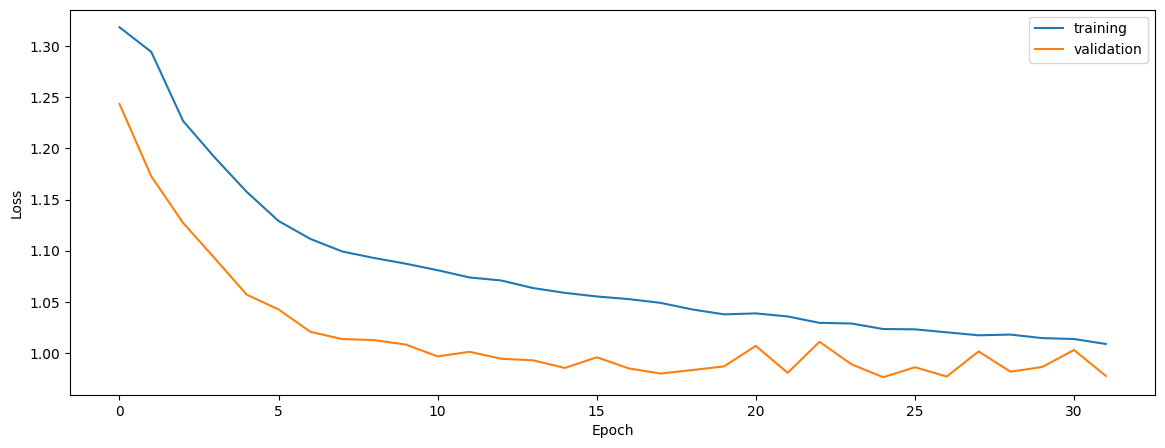

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6397581565138033
0.6540313037865749
0.6270886959556738


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6397581565138033
0.6540313037865749
0.6270886959556738


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6371153200175707
0.6504565958851358
0.6240288042448361


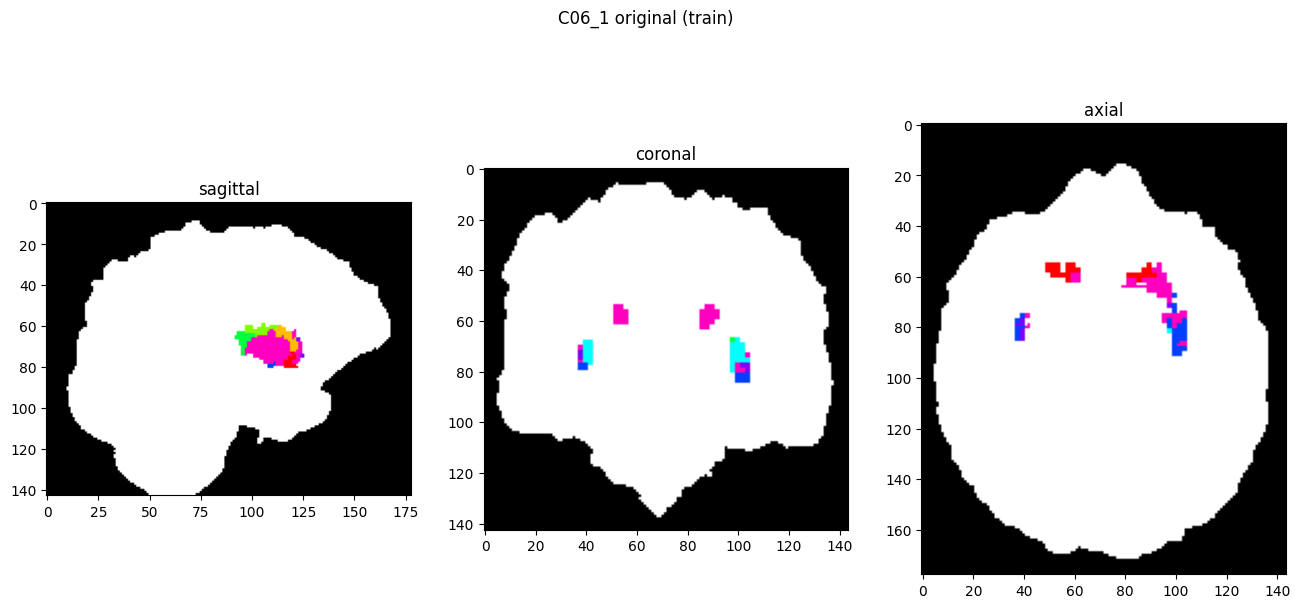

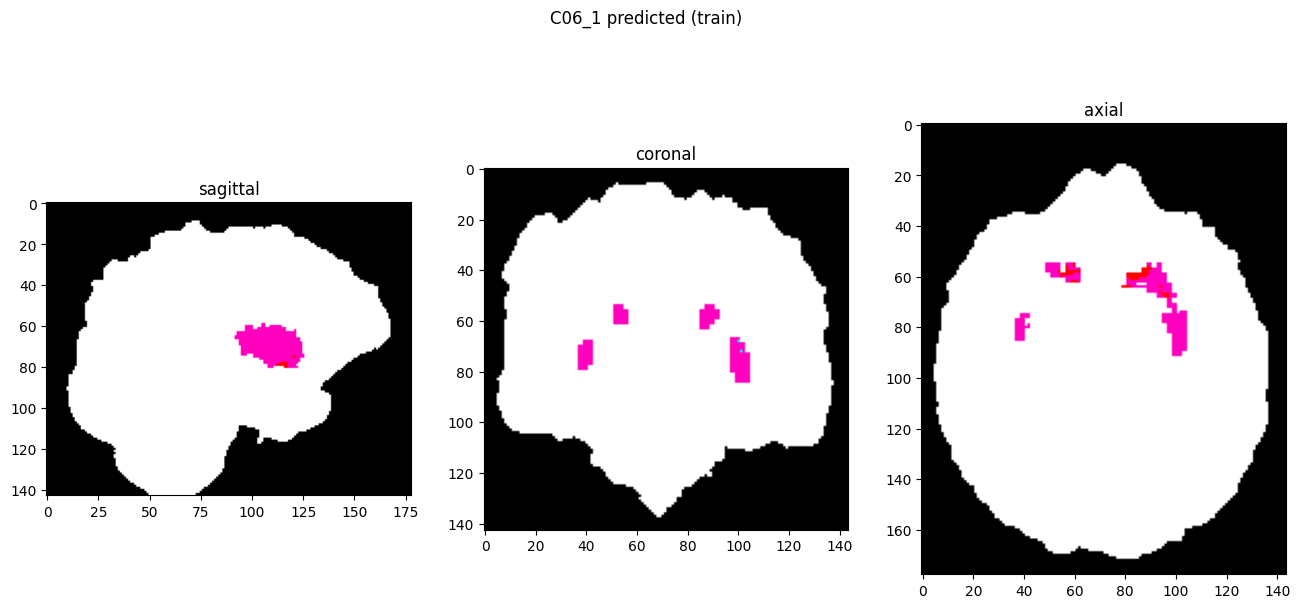

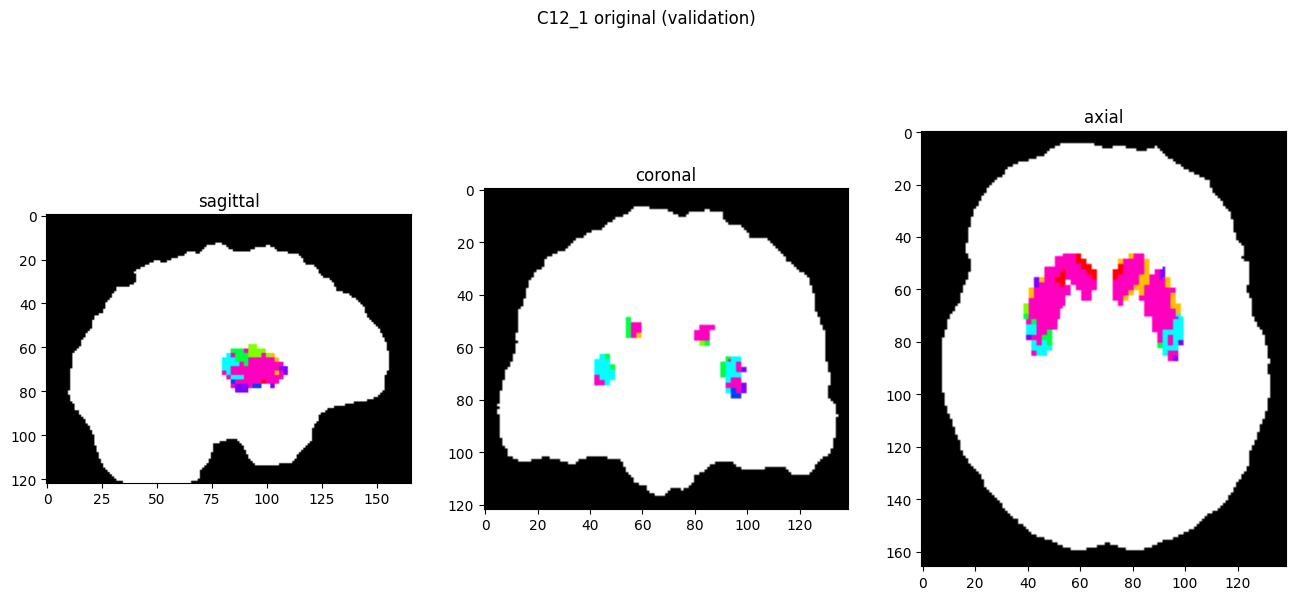

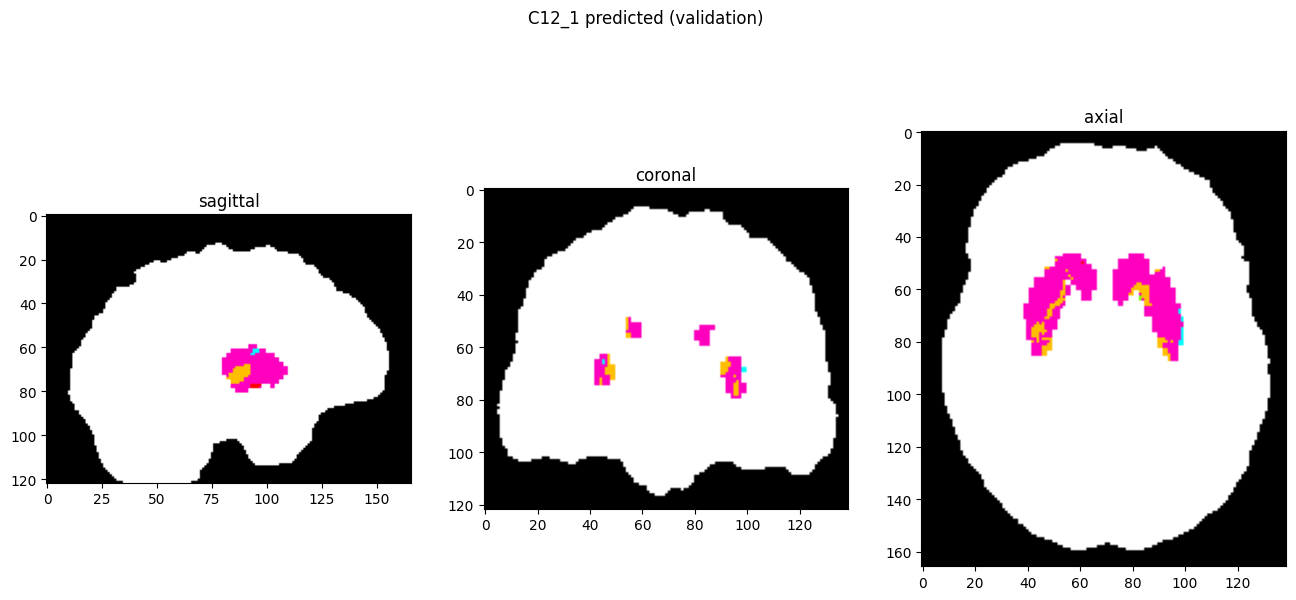

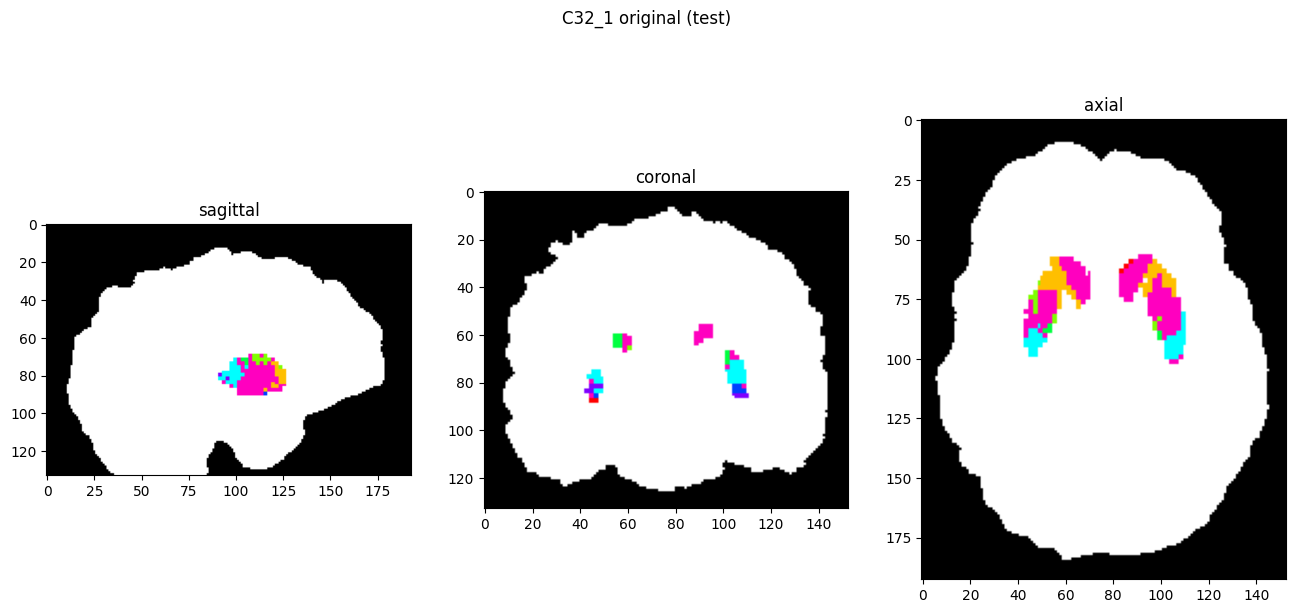

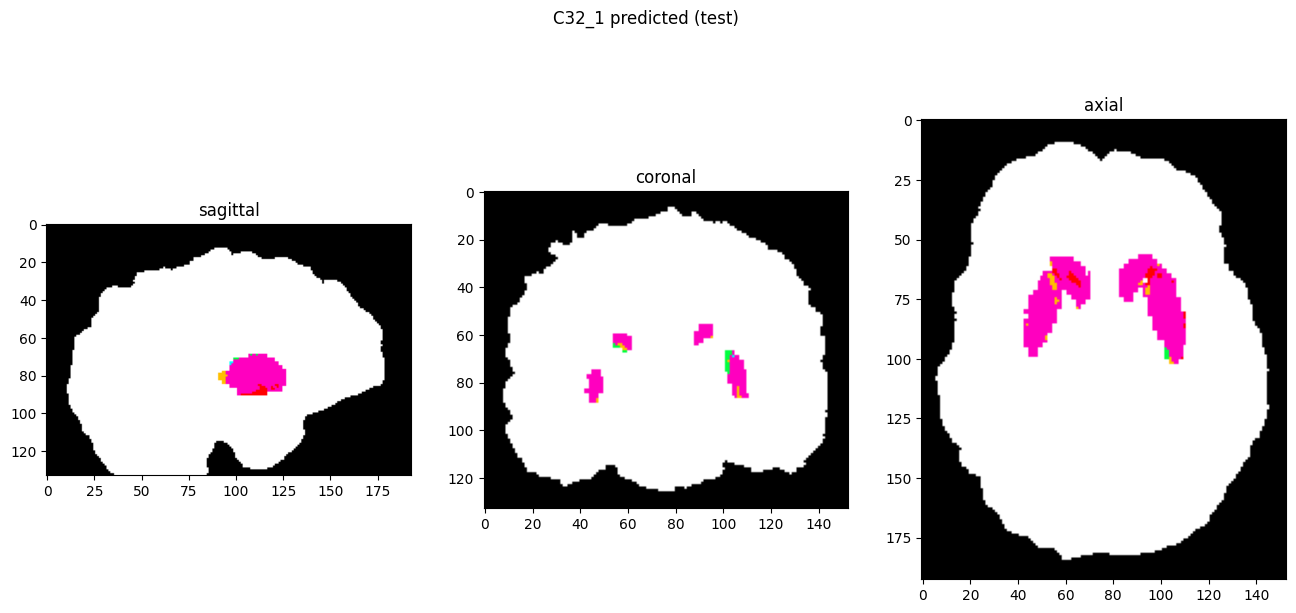

In [10]:
showResults(model, gen, threshold=0)